# <h1><center> Movie Recommendation System </center></h1>

In [7]:
![](https://media.giphy.com/media/3ohhwDMC187JqL69DG/giphy.gif)

'[sad]' is not recognized as an internal or external command,
operable program or batch file.


<a id='Table_Contents'></a><br>
## Table of Contents

[1.Introduction](#Intro)<br>

[2.Imports](#Importing)<br>
* Importing Packages
* Importing Datasets

[3.Data Description](#Data_Description)<br>

[4.Data Preprocessing](#Data_clean)<br>
* Extracting movie years from title
* Removing the pipe '|' 
* IMDB Data Cleaning
* Merging Movies and IMDB data
* Merging Movies,IMDB data and ratings(train)

[5.Exploratory Data Analysis (EDA)](#EDA)<br>
* Title and Overview Wordclouds
* Ratings Average and count

* Movie Release dates
    * Number of movies per year
    * Earliest movies represented 
* Runtime 

* Budget
 
* Genres
* Cast and Crew
* Understanding the Users
    * Check for missing values and extracting datetime
    * Check date/time distribution
    * Users distribution

[6.Modelling](#modelling)<br>
* Singular Value Decomposition (SVD)
* KNNWithMeans
* KNNBasic

[7.Performance Optimization](#performance)<br>

[8.Model Performance](#model_performance)<br>

[9.Recommender System](#recommender)<br>
* Content Based Recommendation
* Collaborative Based Recommendation 

[10.Conclusion](#conclusion)<br>

## 1.Introduction
<a id='Intro'></a> 

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, EDSA has challenged us to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

**Data Overview**

**This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service.** The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!

For this notebook, we'll be using a special version of the MovieLens dataset which has enriched with additional data, and resampled for fair evaluation purposes.

<b>In this notebook, we will look at : </b>
* Model based predictions of ratings
* Matrix Factorisation to predict ratings
* Content based filtering for recommendations
* Collaborative filtering for recommendations 

## 2.Imports
<a id='Importing'></a>
[Back to Table of Contents](#Table_Contents)

<font size="4"><b>Importing Packages</b></font>

In [136]:
# Inspecting
import pandas as pd
import numpy as np
import random
%matplotlib inline
from IPython.display import Image, HTML
pd.set_option('display.max_colwidth',None)
import datetime

#Visuals
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

#Warnings 
import warnings
warnings.filterwarnings('ignore')

#sklearn-surprise for modelling 
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import KNNWithMeans,SVD,KNNBasic,SVDpp
from surprise import Reader, Dataset
reader = Reader()

#Recommender Systems
import os
import heapq
import operator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

#Metrics for analysis 
from surprise import accuracy

#For subset of data
from collections import Counter

#Parameter Tuning
from surprise.model_selection import GridSearchCV

<br><font size="4"><b>Importing Datasets</b></font><br><br>
The data for the MovieLens dataset is maintained by the GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. Additional movie content data was legally scraped from IMDB 

* **genome_scores.csv** - a score mapping the strength between movies and tag-related properties. Read more here
* **genome_tags.csv** - user assigned tags for genome-related scores
* **imdb_data.csv** - Additional movie metadata scraped from IMDB using the links.csv file.
* **links.csv** - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
* **sample_submission.csv** - Sample of the submission format for the hackathon.
* **tags.csv** - User assigned for the movies within the dataset.
* **test.csv** - The test split of the dataset. Contains user and movie IDs with no rating data.
* **train.csv** - The training split of the dataset. Contains user and movie IDs with associated rating data.

In [15]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
tags = pd.read_csv('tags.csv')
movies = pd.read_csv('movies.csv')
links = pd.read_csv('links.csv')
imdb_data = pd.read_csv('imdb_data.csv')
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')

## 3. Data Description
<a id='Data_Description'></a>
[Back to Table of Contents](#Table_Contents)

Let us take a look at the number of rows and columns in each dataset.

In [20]:
#Looking at the number of rows and columns of each dataframe 
print("Train data contains {} rows and {} columns".format(train.shape[0], train.shape[1]))
print("Test data contains {} rows and {} columns".format(links.shape[0], links.shape[1]))
print("Movies data contains {} rows and {} columns".format(movies.shape[0], movies.shape[1]))
print("IMDB data contains {} rows and {} columns".format(imdb_data.shape[0], imdb_data.shape[1]))
print("Tags data contains {} rows and {} columns".format(tags.shape[0], tags.shape[1]))
print("Genome tags data contains {} rows and {} columns".format(genome_tags.shape[0], genome_tags.shape[1]))
print("Genome scores data contains {} rows and {} columns".format(genome_scores.shape[0], genome_scores.shape[1]))
print("Links data contains {} rows and {} columns".format(links.shape[0], links.shape[1]))

Train data contains 10000038 rows and 4 columns
Test data contains 62423 rows and 3 columns
Movies data contains 62423 rows and 3 columns
IMDB data contains 27278 rows and 6 columns
Tags data contains 1093360 rows and 4 columns
Genome tags data contains 1128 rows and 2 columns
Genome scores data contains 15584448 rows and 3 columns
Links data contains 62423 rows and 3 columns


**Now let's take a look at the first few rows of each dataframe and it's info.**<br><br>
We will not be using the links dataset as it is just used in a database as a mapping table. The genome scores dataset is also of no use to us since we are more interested in the ratings,users and movies data for our predictions.

**train(ratings)**

In [21]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


**test**

In [22]:
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


**movies**

In [26]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [27]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


**imdb_data**

In [28]:
imdb_data.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wallace Shawn|John Ratzenberger|Annie Potts|John Morris|Erik von Detten|Laurie Metcalf|R. Lee Ermey|Sarah Freeman|Penn Jillette|Jack Angel|Spencer Aste,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bradley Pierce|Bonnie Hunt|Bebe Neuwirth|David Alan Grier|Patricia Clarkson|Adam Hann-Byrd|Laura Bell Bundy|James Handy|Gillian Barber|Brandon Obray|Cyrus Thiedeke|Gary Joseph Thorup,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Margret|Burgess Meredith|Daryl Hannah|Kevin Pollak|Katie Sagona|Ann Morgan Guilbert|James Andelin|Marcus Klemp|Max Wright|Cheryl Hawker|Wayne A. Evenson|Allison Levine,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|Lela Rochon|Gregory Hines|Dennis Haysbert|Mykelti Williamson|Michael Beach|Leon|Wendell Pierce|Donald Faison|Jeffrey D. Sams|Jazz Raycole|Brandon Hammond|Kenya Moore,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betrayal|mother son relationship
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberly Williams-Paisley|George Newbern|Kieran Culkin|BD Wong|Peter Michael Goetz|Kate McGregor-Stewart|Jane Adams|Eugene Levy|Rebecca Chambers|April Ortiz|Dulcy Rogers|Kathy Anthony,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [29]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


**genome tags**

In [31]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [32]:
genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


**tags**

In [34]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [36]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


## 4. Data Preprocessing
<a id='Data_clean'></a>
[Back to Table of Contents](#Table_Contents) 

In this step we will attempt at learning more about our features and performing appropriate preprocessing steps to arrive at a form that is more suitable for analysis.<br>
We will also be merging the relevant datasets to help us accquire a more robust set on which we eda can be performed.

<font size="4"><b>Extracting movie years from title</b></font><br><br>
Looking at the **Title column in movies.csv**, we can see that years appear as part of the title. We will then separate years from titles and create a new column for **Year**. We will then be able to analyse movies by year of release.

In [41]:
#Remove Years from titles and create a separate year column
movies['year'] = movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
movies['year'] = movies.year.str.extract('(\d\d\d\d)',expand=False)

In [42]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


<font size="4"><b>Removing the pipe '|'</b></font><br><br>
We also can see that the genres are separated by a vertical bar, or the pipe. We will go ahead and remove this for all the given datasets.

In [43]:
# Split genre data into individual words.
movies['genres'] = movies['genres'].apply(lambda x: x.replace('|',' ').lower())
# Split title_cast data into individual words.
imdb_data['title_cast'] = imdb_data['title_cast'].apply(lambda x: x.replace('|',' ').lower() if x == x else np.nan)
# Split plot_keywords data into individual words.
imdb_data['plot_keywords'] = imdb_data['plot_keywords'].apply(lambda x: x.replace('|',' ').lower() if x == x else np.nan)

In [44]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),adventure animation children comedy fantasy,1995
1,2,Jumanji (1995),adventure children fantasy,1995
2,3,Grumpier Old Men (1995),comedy romance,1995
3,4,Waiting to Exhale (1995),comedy drama romance,1995
4,5,Father of the Bride Part II (1995),comedy,1995


In [45]:
imdb_data.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,tom hanks tim allen don rickles jim varney wallace shawn john ratzenberger annie potts john morris erik von detten laurie metcalf r. lee ermey sarah freeman penn jillette jack angel spencer aste,John Lasseter,81.0,"$30,000,000",toy rivalry cowboy cgi animation
1,2,robin williams jonathan hyde kirsten dunst bradley pierce bonnie hunt bebe neuwirth david alan grier patricia clarkson adam hann-byrd laura bell bundy james handy gillian barber brandon obray cyrus thiedeke gary joseph thorup,Jonathan Hensleigh,104.0,"$65,000,000",board game adventurer fight game
2,3,walter matthau jack lemmon sophia loren ann-margret burgess meredith daryl hannah kevin pollak katie sagona ann morgan guilbert james andelin marcus klemp max wright cheryl hawker wayne a. evenson allison levine,Mark Steven Johnson,101.0,"$25,000,000",boat lake neighbor rivalry
3,4,whitney houston angela bassett loretta devine lela rochon gregory hines dennis haysbert mykelti williamson michael beach leon wendell pierce donald faison jeffrey d. sams jazz raycole brandon hammond kenya moore,Terry McMillan,124.0,"$16,000,000",black american husband wife relationship betrayal mother son relationship
4,5,steve martin diane keaton martin short kimberly williams-paisley george newbern kieran culkin bd wong peter michael goetz kate mcgregor-stewart jane adams eugene levy rebecca chambers april ortiz dulcy rogers kathy anthony,Albert Hackett,106.0,"$30,000,000",fatherhood doberman dog mansion


<font size="4"><b>IMDB Data Cleaning</b></font><br><br>
The **budget** values are assigned generic object status. We will then clean it, convert into integers and convert NaN values to 0 values to indicate absence of information.

In [46]:
#we remove all commas
imdb_data['budget'] = imdb_data['budget'].str.replace(',', '')
#we remove all currency signs like "$" and "GBP"
imdb_data['budget'] = imdb_data['budget'].str.extract('(\d+)', expand=False)
#converting the feature into a float
imdb_data['budget'] = imdb_data['budget'].astype(float)
#removing NaN values and replacing with 0
imdb_data['budget'] = imdb_data['budget'].replace(np.nan,0)
#converting the feature into an integer
imdb_data['budget'] = imdb_data['budget'].astype(int)

In [49]:
#For uniformity and better utilisation on the app. 
## We will convert director names into smaller letters and drop NaN values.
imdb_data['director'] = imdb_data['director'].apply(lambda x: x.lower() if x == x else np.nan)

In [51]:
imdb_data.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,tom hanks tim allen don rickles jim varney wallace shawn john ratzenberger annie potts john morris erik von detten laurie metcalf r. lee ermey sarah freeman penn jillette jack angel spencer aste,john lasseter,81.0,30000000,toy rivalry cowboy cgi animation
1,2,robin williams jonathan hyde kirsten dunst bradley pierce bonnie hunt bebe neuwirth david alan grier patricia clarkson adam hann-byrd laura bell bundy james handy gillian barber brandon obray cyrus thiedeke gary joseph thorup,jonathan hensleigh,104.0,65000000,board game adventurer fight game
2,3,walter matthau jack lemmon sophia loren ann-margret burgess meredith daryl hannah kevin pollak katie sagona ann morgan guilbert james andelin marcus klemp max wright cheryl hawker wayne a. evenson allison levine,mark steven johnson,101.0,25000000,boat lake neighbor rivalry
3,4,whitney houston angela bassett loretta devine lela rochon gregory hines dennis haysbert mykelti williamson michael beach leon wendell pierce donald faison jeffrey d. sams jazz raycole brandon hammond kenya moore,terry mcmillan,124.0,16000000,black american husband wife relationship betrayal mother son relationship
4,5,steve martin diane keaton martin short kimberly williams-paisley george newbern kieran culkin bd wong peter michael goetz kate mcgregor-stewart jane adams eugene levy rebecca chambers april ortiz dulcy rogers kathy anthony,albert hackett,106.0,30000000,fatherhood doberman dog mansion


<font size="4"><b>Merging Movies and IMDB data</b></font><br><br>
From just looking at our data, it looks like we will be using **Movies** and **IMDB** data a lot. So, it makes sense to join the two datasets.

In [52]:
# This join makes sure imdb is added to movies and all movie rows are kept
movies_imdb = movies.join(imdb_data.set_index('movieId'),on='movieId')
movies_imdb.head()

,movieId,title,genres,year,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),adventure animation children comedy fantasy,1995,tom hanks tim allen don rickles jim varney wallace shawn john ratzenberger annie potts john morris erik von detten laurie metcalf r. lee ermey sarah freeman penn jillette jack angel spencer aste,john lasseter,81.0,30000000.0,toy rivalry cowboy cgi animation
1,2,Jumanji (1995),adventure children fantasy,1995,robin williams jonathan hyde kirsten dunst bradley pierce bonnie hunt bebe neuwirth david alan grier patricia clarkson adam hann-byrd laura bell bundy james handy gillian barber brandon obray cyrus thiedeke gary joseph thorup,jonathan hensleigh,104.0,65000000.0,board game adventurer fight game
2,3,Grumpier Old Men (1995),comedy romance,1995,walter matthau jack lemmon sophia loren ann-margret burgess meredith daryl hannah kevin pollak katie sagona ann morgan guilbert james andelin marcus klemp max wright cheryl hawker wayne a. evenson allison levine,mark steven johnson,101.0,25000000.0,boat lake neighbor rivalry
3,4,Waiting to Exhale (1995),comedy drama romance,1995,whitney houston angela bassett loretta devine lela rochon gregory hines dennis haysbert mykelti williamson michael beach leon wendell pierce donald faison jeffrey d. sams jazz raycole brandon hammond kenya moore,terry mcmillan,124.0,16000000.0,black american husband wife relationship betrayal mother son relationship
4,5,Father of the Bride Part II (1995),comedy,1995,steve martin diane keaton martin short kimberly williams-paisley george newbern kieran culkin bd wong peter michael goetz kate mcgregor-stewart jane adams eugene levy rebecca chambers april ortiz dulcy rogers kathy anthony,albert hackett,106.0,30000000.0,fatherhood doberman dog mansion


We now have a a dataframe that has almost all the columns that we need to start our **EDA**.

<font size="4"><b>Merging Movies,IMDB data and ratings(train)</b></font><br><br>
Upon further look we realised that we are missing one of the key features used when considering or recommending a movie. It will definitely help to have ratings of each film!

In [54]:
#We are not planning to utilise timestamp so we will drop this column.
ratings = train.drop(columns=['timestamp'])
ratings.head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


In [55]:
#Merge train and movies to get ratings
df = ratings.join(movies_imdb.set_index('movieId'),on = 'movieId')

In [56]:
df.head()

,userId,movieId,rating,title,genres,year,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,In Bruges (2008),comedy crime drama thriller,2008,elizabeth berrington rudy blomme olivier bonjour mark donovan ann elsley colin farrell jean-marc favorin ralph fiennes brendan gleeson eric godon zeljko ivanek sachi kimura anna madeley louis nummy clémence poésy,martin mcdonagh,107.0,15000000.0,dwarf bruges irish hitman
1,106343,5,4.5,Father of the Bride Part II (1995),comedy,1995,steve martin diane keaton martin short kimberly williams-paisley george newbern kieran culkin bd wong peter michael goetz kate mcgregor-stewart jane adams eugene levy rebecca chambers april ortiz dulcy rogers kathy anthony,albert hackett,106.0,30000000.0,fatherhood doberman dog mansion
2,146790,5459,5.0,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (2002),action comedy sci-fi,2002,tommy lee jones will smith rip torn lara flynn boyle johnny knoxville rosario dawson tony shalhoub patrick warburton jack kehler david cross colombe jacobsen-derstine peter spellos michael rivkin michael bailey smith lenny venito,lowell cunningham,88.0,140000000.0,lingerie michael jackson character shorthaired woman calzone
3,106362,32296,2.0,Miss Congeniality 2: Armed and Fabulous (2005),adventure comedy crime,2005,sandra bullock regina king enrique murciano william shatner ernie hudson heather burns diedrich bader treat williams abraham benrubi nick offerman eileen brennan elisabeth röhm leslie grossman lusia strus molly gottlieb,marc lawrence,115.0,45000000.0,female protagonist cleave gag good woman fbi
4,9041,366,3.0,"Wes Craven's New Nightmare (Nightmare on Elm Street Part 7: Freddy's Finale, A) (1994)",drama horror mystery thriller,1994,jeff davis heather langenkamp miko hughes matt winston rob labelle david newsom wes craven marianne maddalena gretchen oehler tracy middendorf cully fredricksen bodhi elfman sam rubin robert englund claudia haro,wes craven,112.0,8000000.0,freddy krueger elm street famous director as himself alternate reality


In [57]:
#We compare the length of our ratings data to that of ratings to ensure that we have all the data.
print(len(ratings) == len(df),len(ratings) ,'==',len(df))

True 10000038 == 10000038


## 4.Exploratory Data Analysis (EDA) 
<a id='EDA'></a>
[Back to Table of Contents](#Table_Contents)

<font size="4"><b>Title and Overview Wordclouds</b></font><br><br>
We will have a look at the title and the given plot words to determine if there are recurring words or words that are more common in both the way movies get titles and also how movies tend to be described.

In [58]:
movies['title'] = movies['title'].astype('str')
plot_cloud = imdb_data.loc[:,'plot_keywords'] = imdb_data.loc[:, 'plot_keywords'].astype(str)
plot_cloud.dropna()

0                                                 toy rivalry cowboy cgi animation
1                                                 board game adventurer fight game
2                                                       boat lake neighbor rivalry
3        black american husband wife relationship betrayal mother son relationship
4                                                  fatherhood doberman dog mansion
                                           ...                                    
27273        man wrapped in a towel man wears a thong male rear nudity male nudity
27274                             ski ski resort ampersand in title drink in title
27275                                              pirate sword fight korea bandit
27276                                 friend friendship television show restaurant
27277                                                       hex witch virgin blood
Name: plot_keywords, Length: 27278, dtype: object

In [59]:
title_corpus = ' '.join(movies['title'])
plot_corpus = ' '.join(plot_cloud)

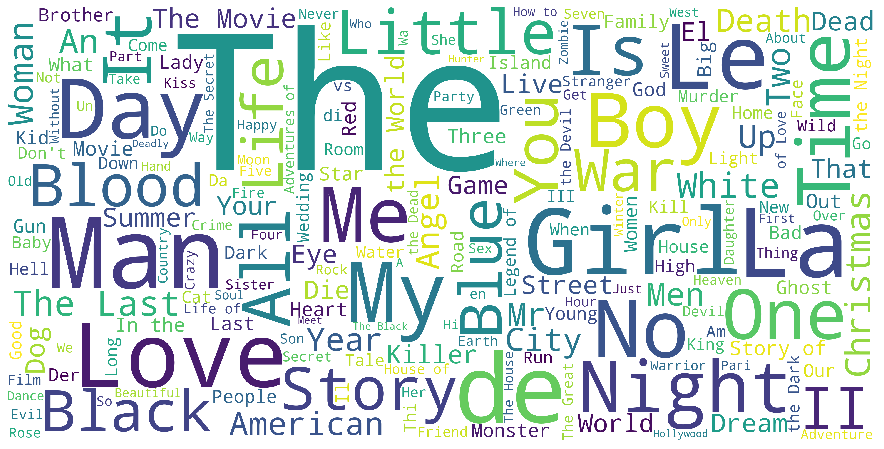

In [60]:
# Generate a wordcloud for the titles of movies
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

The word **Love** is the most commonly used word in movie titles.  **Man** is also a very common word, and this is closely followed by **Girl** which makes for an interesting thought on gender representation in film. Love is perhaps so common because romance is often present in movies of all genres.

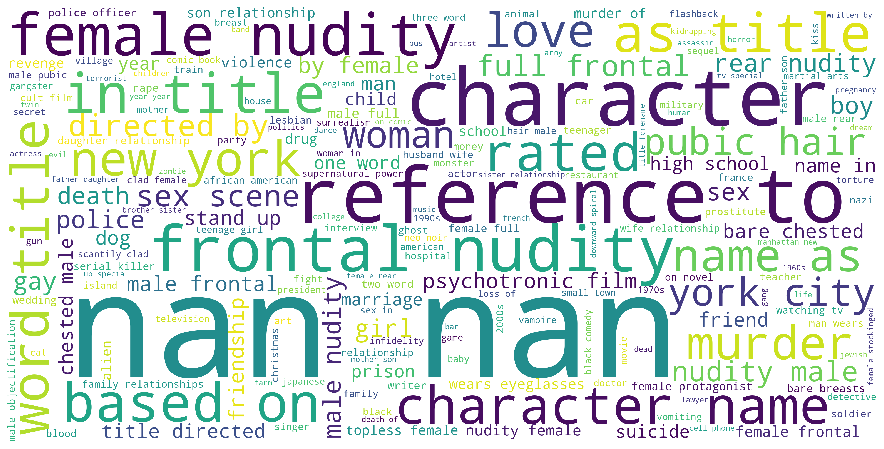

In [61]:
# Generate wordcloud for the plot keywords of movies
plot_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(plot_corpus)
plt.figure(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.show()

Looking at the plot keywords, there seems to be a lot of emphasis on **nudity**. When it comes to locations, **New York** is the popular city. **reference, character, female, rated, murder and word title** are other words that pop out. 

<font size="4"><b>Rating Average and Count</b></font><br><br>
We will have a look at the title and the given plot words to determine if there are recurring words or words that are more common in both the way movies get titles and also how movies tend to be described.

In [62]:
df.groupby('title').count().head()

,userId,movieId,rating,genres,year,title_cast,director,runtime,budget,plot_keywords
title,,,,,,,,,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",1,1,1,1,1,0,0,0,0,0
"""Great Performances"" Cats (1998)",67,67,67,67,67,67,67,67,67,67
#1 Cheerleader Camp (2010),5,5,5,5,5,0,0,0,0,0
#Female Pleasure (2018),1,1,1,1,1,0,0,0,0,0
#FollowMe (2019),5,5,5,5,5,0,0,0,0,0


In [65]:
# Viewing the top rated movies based on their mean ratings and vote vounts  
group_title = df.groupby('title').agg({'rating':['count','mean']})['rating']
group_title.sort_values(['count','mean'],ascending=False,inplace=True)
group_title.head(10)

,count,mean
title,,
"Shawshank Redemption, The (1994)",32831,4.417624
Forrest Gump (1994),32383,4.047216
Pulp Fiction (1994),31697,4.195097
"Silence of the Lambs, The (1991)",29444,4.144172
"Matrix, The (1999)",29014,4.154253
Star Wars: Episode IV - A New Hope (1977),27560,4.111811
Jurassic Park (1993),25518,3.684634
Schindler's List (1993),24004,4.247625
Braveheart (1995),23722,3.994119


The Shawshank Redemption and Forrest Gump are the two most critically acclaimed movies in the TMDB Database. Interestingly, they are the top 2 movies in IMDB's Top 250 Movies list too. They have a rating of over 9 on IMDB as compared to their 8.5 TMDB Scores.

In [68]:
# Subset of the movies based on mocies that have a vote count above 100
new_group = group_title[group_title['count'] > 100]
new_group = new_group.sort_values(['mean','count'],ascending=False)
new_group.head()

,count,mean
title,,
Planet Earth II (2016),439,4.517084
Planet Earth (2006),674,4.473294
Cosmos,116,4.456897
"Shawshank Redemption, The (1994)",32831,4.417624
Band of Brothers (2001),575,4.399130
The Blue Planet (2001),216,4.337963
"Godfather, The (1972)",20960,4.311355
Human Planet (2011),132,4.295455
Blue Planet II (2017),264,4.291667


In [74]:
# min and max mean ratings 
print("The maximum mean rating is "+ str(round(new_group['mean'].max(),2)))
print("The minimum mean rating is "+ str(round(new_group['mean'].min(),2)))

The maximum mean rating is 4.52
The minimum mean rating is 1.01


Let us examine the summary statistics and the distribution of each feature one by one.

In [75]:
new_group['mean'].describe()

count    7286.000000
mean        3.330875
std         0.498178
min         1.011236
25%         3.033197
50%         3.409717
75%         3.711516
max         4.517084
Name: mean, dtype: float64

All movies have a rating score less than 5 (the 75th percentile is at 3.711). The **Max Rating is 4.51** and **the lowest is 1.01**

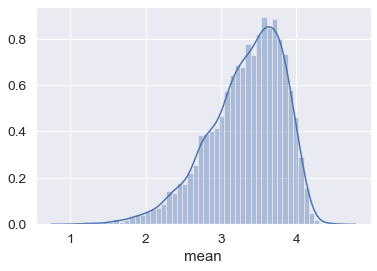

In [82]:
# Distribution of rating means for movies with more than 100 votes
sns.distplot(new_group['mean'].fillna(new_group['mean'].median()))
plt.show()

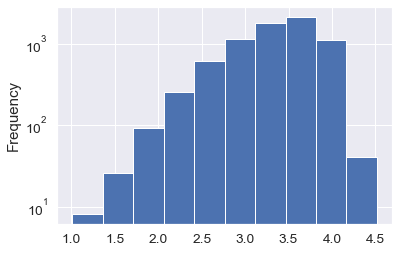

In [83]:
new_group['mean'].plot(logy=True, kind='hist')

The rating score has a mean of  **3.5** and maximum values of **4.5**. (Movies with less than 100 ratings have been removed.) 

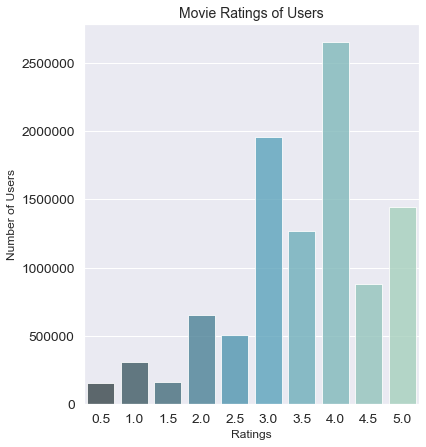

In [81]:
#bar graph plot to show the ratings of movies given by users
cnt_srs = train['rating'].value_counts()

plt.figure(figsize=(6,7))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette='GnBu_d')
plt.title('Movie Ratings of Users', fontsize=14)
plt.ylabel('Number of Users', fontsize=12)
plt.xlabel('Ratings', fontsize=12)
plt.xticks([0,1,2,3,4,5,6,7,8,9],['0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0'])
plt.show()

The above bar graph shows the ratings of movies given by users. We notice a rating of 4.0 as being the most frequent rating being given to movies by users.

As with popularity scores, the distribution of vote counts is extremely skewed with the median vote count standing at a paltry 10 votes. The most votes a single movie has got stands at 14,075. TMDB Votes, therefore, are not as potent and suggestive as its IMDB Counterpart. Nevertheless, let us check which the most voted on movies on the website are.

<font size="4"><b>Movie Release Dates</b></font><br><br>
Release Dates can often play a very important role in determining the success and the revenue generated by a particular movie. In this section, we will try and gain insights about release dates in terms of years, months and days of the week. 

We have already constructed the **year** feature in our preliminary data wrangling step. Let us now extract the month and day too for each movie with a release date.

<font size="3"><b>Number of Movies per year</b></font><br><br>
The Dataset of 45,000 movies available to us does not represent the entire corpus of movies released since the inception of cinema. However, it is reasomnable to assume that it does include almost every major film released in Hollywood as well as other major film industries across the world (such as Bollywood in India). With this assumption in mind, let us take a look at the number of movies produced by the year.

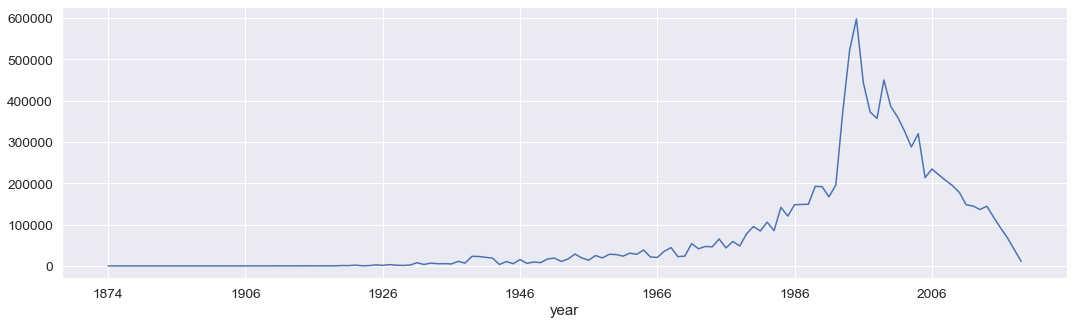

In [84]:
year_count = df.groupby('year')['title'].count()
plt.figure(figsize=(18,5))
year_count.plot()

We notice that there is a sharp rise in the number of movies **starting the 1990s decade.** However, we will not look too much into this as it is entirely possible that recent movies were oversampled for the purposes of this dataset.

Next, let us take a look at the earliest movies represented in the dataset.

<font size="3"><b>Earliest Movies Represented</b></font>

In [86]:
df[df['year'] != 'NaT'][['title', 'year']].sort_values('year').head(10)

,title,year
7223940,Passage de Venus (1874),1874
6084059,Passage de Venus (1874),1874
1543753,Sallie Gardner at a Gallop (1878),1878
4161502,Sallie Gardner at a Gallop (1878),1878
3052771,Sallie Gardner at a Gallop (1878),1878
4599943,Sallie Gardner at a Gallop (1878),1878
6231122,Sallie Gardner at a Gallop (1878),1878
5826234,Sallie Gardner at a Gallop (1878),1878
3960408,Buffalo Running (1883),1883
8847089,Buffalo Running (1883),1883


The oldest film is Passage of Venus	from 1874. 

<font size="4"><b>Runtime</b></font><br><br>
From its humble beginnings of 1 minute silent, black & white clips to epic 3 hour visual delights, movies have a come a long way in terms of runtime. In this section, let us try and gain some additional insights about the nature of movie lengths and their evolution over time.

In [87]:
imdb_data['runtime'].describe()

count    15189.000000
mean       100.312331
std         31.061707
min          1.000000
25%         89.000000
50%         98.000000
75%        109.000000
max        877.000000
Name: runtime, dtype: float64

The average length of a movie is about 1 hour and 40 minutes. The longest movie on record in this dataset is a **staggering 877 minutes (or 14.6 hours) long.** **NB, DATA MAY CONTAIN SOME SERIES HENCE THE HIGH RUNTIME ON SOME**

We are aware that most movies are less than 5 hours (or 300 minutes) long. Let us plot a distribution of these mainstream movies.

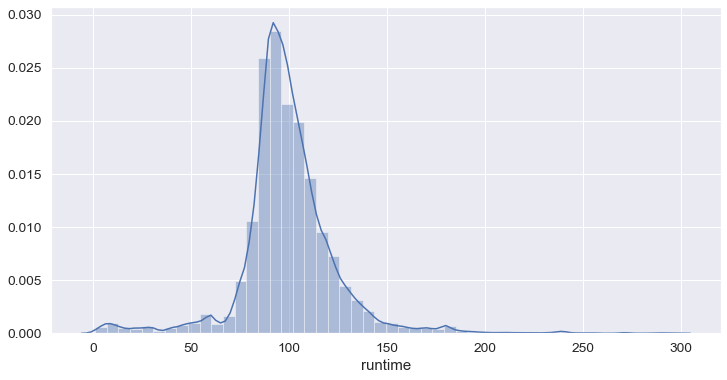

In [89]:
imdb_data['runtime'] = imdb_data['runtime'].astype('float')
plt.figure(figsize=(12,6))
sns.distplot(imdb_data[(imdb_data['runtime'] < 300) & (imdb_data['runtime'] > 0)]['runtime'])

As we can see from the above distribution graph for the runtime of movies, that the most common duration of a movie is around 90 minutes.

<font size="4"><b>Budget</b></font><br><br>
Let us now turn our attention to budget. We expect budgets to be a skewed quantity and also heavily influenced by inflation. Nevertheless, it would be interesting to gather as much insights as possible from this quantity as budget is often a critical feature in predicting movie revenue and success. As a start, let us gather the summary statistics for our budget.

In [90]:
imdb_data['budget'].describe()

count    2.727800e+04
mean     6.897762e+06
std      6.471789e+07
min     -2.147484e+09
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+06
max      2.000000e+09
Name: budget, dtype: float64

The mean budget of a film is 21.6 million dollars whereas the median budget is far smaller at 8 million dollars. This strongly suggests the mean being influenced by outliers. 

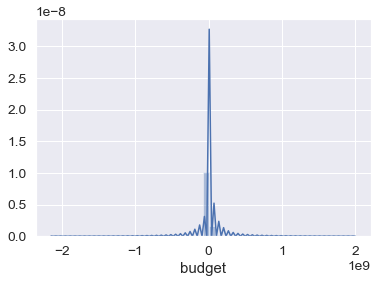

In [91]:
sns.distplot(imdb_data[imdb_data['budget'].notnull()]['budget'])

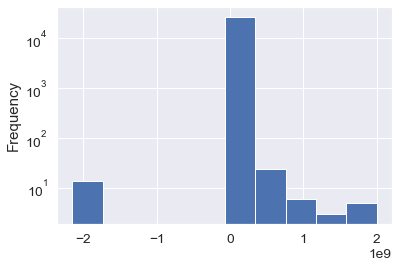

In [92]:
imdb_data['budget'].plot(logy=True, kind='hist')

The distribution of movie budgets shows an exponential decay. More than 75% of the movies have a budget smaller than 25 million dollars. Next, let us take a look at the most expensive movies of all time and the revenue & returns that they generated.

<font size="4"><b>Movie Release Dates</b></font><br><br>
Let us take a look at the various genres of movies as this may provide insights as to the preferences of users. This is also vital to our content based movie recommender later in the notebook.

In [94]:
genres = ["Action","Adventure","Animation","Children","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western","(no genres listed)"]

In [96]:
# Viewing the number of movies in the different genres, some movies are calssified as having multiple genres
num_mov = [len(movies[movies['genres'].str.contains(genre.lower())]) for genre in genres]
d = {"Genres":genres,"Movies":num_mov}
mov_gen = pd.DataFrame(d)
mov_gen.sort_values('Movies',ascending=False,inplace=True)
mov_gen.reset_index(drop=True,inplace=True)
mov_gen.head(20)

,Genres,Movies
0,Drama,25606
1,Comedy,16870
2,Thriller,8654
3,Romance,7719
4,Action,7348
5,Horror,5989
6,Documentary,5605
7,Crime,5319
8,(no genres listed),5062
9,Adventure,4145


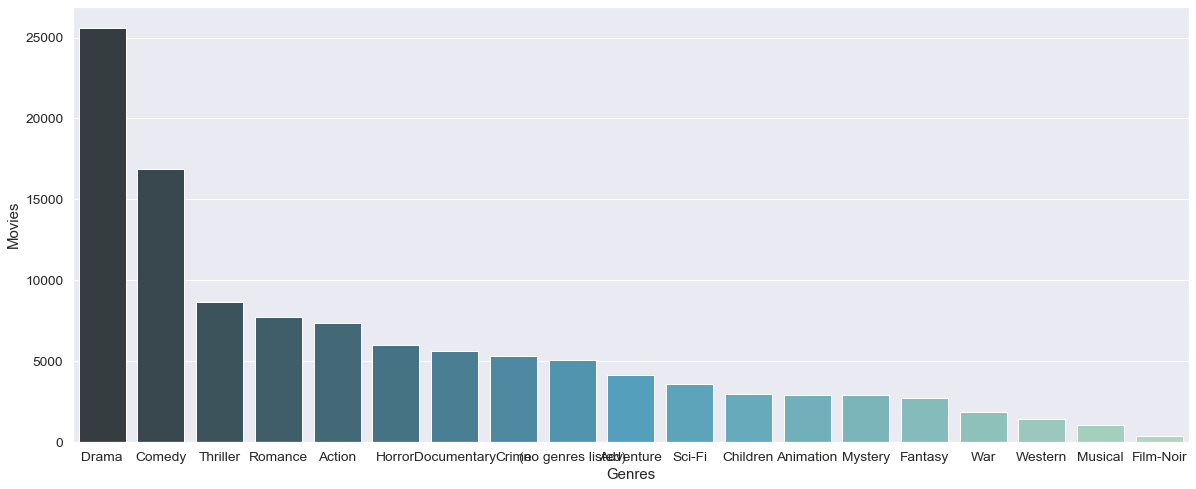

In [98]:
#bargraph illustrating the distribution of movies throughout the various genres
plt.figure(figsize=(20,8))
sns.barplot(x='Genres', y='Movies', data=mov_gen.head(19), palette='GnBu_d')
plt.show()

**Drama** is the most commonly occurring genre with almost half the movies identifying itself as a drama film. The second one **Comedy** followed by Thriller, Romance, Action, Horror, Documentary, Crime, Adventure, Science Fiction, Children, Animation, Mystery and Fantasy.

<font size="4"><b>Movie Release Dates</b></font><br><br>
We have a better idea on the movies, their popularity or lack of. Before moving into modeling, let's see if we can get some insights on the user.

In [99]:
users = train.copy()
users.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


<font size="3"><b>Check for missing values and extracting datetime</b></font><br>
We want to be able to analyse user activity by time.

In [105]:
min_time = datetime.datetime.fromtimestamp(min(users.timestamp)).isoformat()
max_time = datetime.datetime.fromtimestamp(max(users.timestamp)).isoformat()
print('Timestamp for ratings from {} to {}:'.format(min_time, max_time))

Timestamp for ratings from 1995-01-09T13:46:49 to 2019-11-21T11:12:29:


In [106]:
def check_missing(data_df):
    """
    Check for missing values in a dataframe. 
    """
    total = data_df.isnull().sum().sort_values(ascending = False)
    percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

check_missing(users)

,timestamp,rating,movieId,userId
Total,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0


In [107]:
check_missing(movies)

,year,genres,title,movieId
Total,410.000000,0.0,0.0,0.0
Percent,0.656809,0.0,0.0,0.0


In [108]:
users = users.join(movies.set_index('movieId'),on='movieId')
users.shape

(10000038, 7)

In [109]:
users['time_dt'] = users['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
users.head()

,userId,movieId,rating,timestamp,title,genres,year,time_dt
0,5163,57669,4.0,1518349992,In Bruges (2008),comedy crime drama thriller,2008,2018-02-11 13:53:12
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),comedy,1995,2008-03-23 04:18:59
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,action comedy sci-fi,2002,2004-02-08 06:45:39
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),adventure comedy crime,2005,2015-02-04 11:36:05
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,drama horror mystery thriller,1994,1996-05-29 15:17:17


In [110]:
users['years'] = users['time_dt'].dt.year
users['month'] = users['time_dt'].dt.month
users['day'] = users['time_dt'].dt.day
users['dayofweek'] = users['time_dt'].dt.dayofweek

users[['years', 'month', 'day', 'dayofweek']].describe()

,years,month,day,dayofweek
count,1.000004e+07,1.000004e+07,1.000004e+07,1.000004e+07
mean,2.008016e+03,6.608953e+00,1.564212e+01,2.967211e+00
std,7.210802e+00,3.506824e+00,8.818277e+00,2.050770e+00
min,1.995000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,2.002000e+03,4.000000e+00,8.000000e+00,1.000000e+00
50%,2.007000e+03,7.000000e+00,1.600000e+01,3.000000e+00
75%,2.015000e+03,1.000000e+01,2.300000e+01,5.000000e+00
max,2.019000e+03,1.200000e+01,3.100000e+01,6.000000e+00


<font size="3"><b>Check date/time distribution</b></font><br>
Let's proceed now to check date/time distribution.

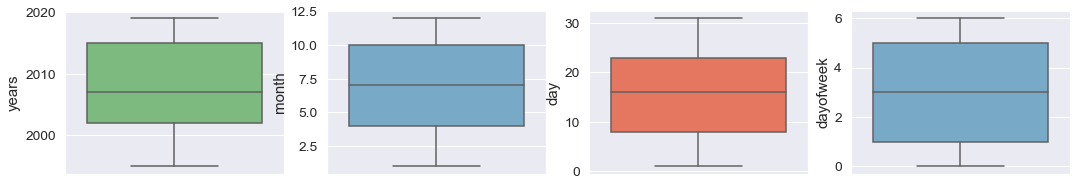

In [125]:
# Distribution of users rating based on date/time
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(18,3))
s = sns.boxplot(ax = ax1, y="years", data=users, palette="Greens",showfliers=True)
s = sns.boxplot(ax = ax2, y="month", data=users, palette="Blues",showfliers=True)
s = sns.boxplot(ax = ax3, y="day", data=users, palette="Reds",showfliers=True)
s = sns.boxplot(ax = ax4, y="dayofweek", data=users, palette="Blues",showfliers=True)
plt.show()

Observations:
* A chunk of rating activity is from is from just before 2010. It also seems like rating is likely to take place from mid-week. Earlier days of the month are also the most active.

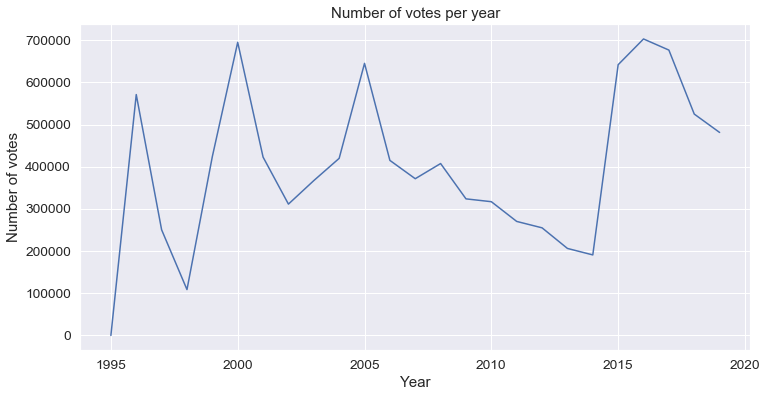

In [115]:
# Plot showing number of votes per year
dt = users.groupby(['years'])['rating'].count().reset_index()
fig, (ax) = plt.subplots(ncols=1, figsize=(12,6))
plt.plot(dt['years'],dt['rating']); plt.xlabel('Year'); plt.ylabel('Number of votes'); plt.title('Number of votes per year')
plt.show()

Observations:
* The year 2000 shows a peak in number of votes after a decline from around 1997. From around 2005 we observe a 10 year drop in ratings. An assumption would be that around this period there was an increase in other online activities like gaming etc. which with users having mutliple screens and sources of entertainment. From 2015 we see another sharp increase that tapers off towards 2020.


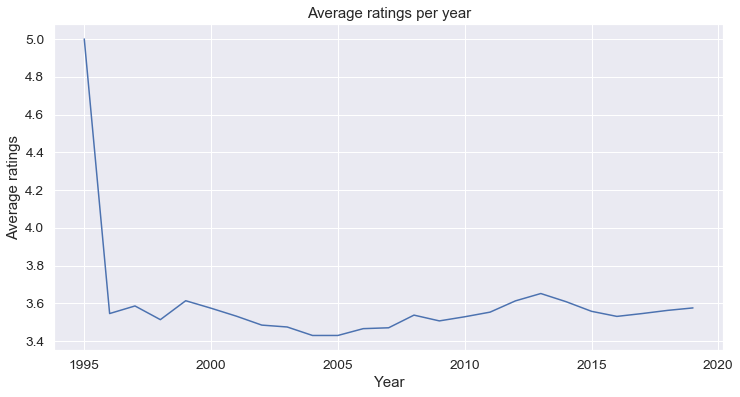

In [116]:
# Plot showing average ratings for each year
dt = users.groupby(['years'])['rating'].mean().reset_index()
fig, (ax) = plt.subplots(ncols=1, figsize=(12,6))
plt.plot(dt['years'],dt['rating']); plt.xlabel('Year'); plt.ylabel('Average ratings'); plt.title('Average ratings per year')
plt.show()

Observations:
* Average ratings are just around **3.5**. The period before 1997 is the anormal as average ratings are around 5. This can be explained by the number of votes in this period. They were lower, and users who rated the movies are probably mainly those who felt compelled to vote favorable.


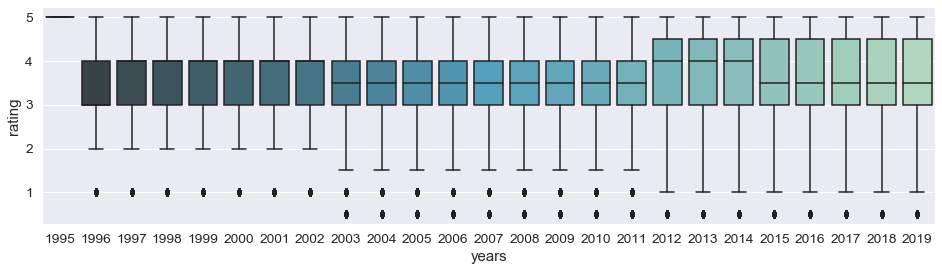

In [118]:
# boxplot of ratings for each year
fig, (ax) = plt.subplots(ncols=1, figsize=(16,4))
s = sns.boxplot(x='years', y="rating", data=users, palette="GnBu_d",showfliers=True)
plt.show()

Observations:
* There are a number of outliers for each year, month and day of week. We observe a strange alignment of the rating distribution per year intervals 1996-2002, **2003-2011(median rating 3.5)** and **2012-2014(median rating 4)** and between **2015 to 2019 median vote is back to 3.5**.

<font size="3"><b>Users distribution</b></font><br>
Let's check if we have special users (users that give many votes, users that give preponderently high ratings, users that give mostly low ratings, users that are giving the perfect average value). Also, users with only one vote.

In [119]:
print("There is a total of {} users, with an average number of {} votes.".format(users.userId.nunique(), \
                                                round(users.shape[0]/users.userId.nunique()),2))

There is a total of 162541 users, with an average number of 62 votes.


In [120]:
print("Top 10 voting users:\n")
tmp = users.userId.value_counts()[:10]
pd.DataFrame({'Votes':tmp.values, 'Id':tmp.index})

Top 10 voting users:



,Votes,Id
0,12952,72315
1,3680,80974
2,3588,137293
3,3208,33844
4,3050,20055
5,2671,109731
6,2670,49403
7,2579,92046
8,2288,110971
9,2284,30879


In [121]:
# Checking users that have only voted once
tmp = users.userId.value_counts()
df = pd.DataFrame({'Votes':tmp.values, 'Id':tmp.index})
print("There are {} users that voted only once.".format(df[df['Votes']==1].nunique().values[0]))

There are 1 users that voted only once.


In [122]:
# CHecking the number of votes for 5 star rating and 0.5 star rating
tmp = users.groupby(['userId'])['rating'].mean().reset_index()
tmp['rating'] = tmp['rating'].apply(lambda x: round(x,3))
df_max = tmp[tmp['rating']==5]
df_min = tmp[tmp['rating']==0.5]
print("Users giving only '5': {}\nUsers giving only '0.5':{}".format(df_max.shape[0], df_min.shape[0]))

Users giving only '5': 423
Users giving only '0.5':21


In [123]:
# Calculating the average rating and comparing users average to this rating 
mean_rating = round(users['rating'].mean(),3)
print("Average value of rating is {}.".format(mean_rating))
print("There are {} users that have their average score with the overall average score (approx. with 3 decimals).".format(\
                            tmp[tmp['rating']==mean_rating]['userId'].nunique()))

Average value of rating is 3.533.
There are 229 users that have their average score with the overall average score (approx. with 3 decimals).


## 7.Modelling
<a id='modelling'></a>
[Back to Table of Contents](#Table_Contents)<br><br>


In this section we will be building various models, that we will use to help predict users ratings on movies they have yet to watch.<br>
We have included a short description of each model and will summarize our findings in the next section.<br> 
<br><b>Models being used:</b><br>
* Matrix Factorization
    * Singular Value Decomposition (SVD)
* K-Nearest Neighbors
    * KNNWithMeans
    * KNNBasic
  

<font size="4"><b>Collaborative Filtering</b></font><br><br>
Model-based Collaborative Filtering is based on matrix factorization (MF) which has received greater exposure, mainly as an unsupervised learning method for 
latent variable decomposition and dimensionality reduction. 
Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF

<font size="4"><b>Singular Value Decomposition (SVD)</b></font><br><br>

SVD in the context of recommendation systems is used as a collaborative filtering (CF) algorithm. Collaborative filtering is a method to predict a rating for a user item pair based on the history of ratings given by the user and given to the item. Most CF algorithms are based on user-item rating matrix where each row represents a user, each column an item. The entries of this matrix are ratings given by users to items.<br>

SVD is a matrix factorization technique that is usually used to reduce the number of features of a data set by reducing space dimensions from N to K where K < N. <br>

<b>Advantages :</b>
* Can be used on a large dataset.
* Takes into account Principal Component Analysis (PCA).
* Uses matrix and applies dimensionality reduction.

Loading datasets for SVD model

In [ ]:
#Initialising a reader to read in and load data from the train df for use in our SVD model
reader = Reader(rating_scale = (0.5, 5))
data = Dataset.load_from_df(train[['userId','movieId','rating']], reader)
#building a full train set for our Kaggle Submission 
train_set = data.build_full_trainset()

Splitting the ratings dataset into train and test sets

In [ ]:
trainset,testset = train_test_split(data,test_size=0.2,random_state=42)

Initialising the SVD model and fitting the train set

In [ ]:
model = SVD()
model.fit(trainset)

Making predictions and calculating the local rmse 

In [ ]:
model.predict('userId','itemId')
predictions = model.test(testset)
accuracy.rmse(predictions)

<font size="4"><b>K-Nearest Neighbors Algorithms</b></font><br><br>
The k-nearest neighbors (KNN) algorithm is a simple, supervised machine learning algorithm that can be used to solve both classification and regression problems. It’s easy to implement and understand, but has a major drawback of becoming significantly slows as the size of that data in use grows.

KNN works by finding the distances between a query and all the examples in the data, selecting the specified number examples (K) closest to the query, then votes for the most frequent label (in the case of classification) or averages the labels (in the case of regression).<br><br> 

<b>Advantages :</b>

* The algorithm is simple and easy to implement.
* There’s no need to build a model, tune several parameters, or make additional assumptions.
* The algorithm is versatile. It can be used for classification, regression, and search.

<b>User-User Collaborative Filtering:</b> Here we find look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past. 
This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. 


<b>Item-Item Collaborative Filtering:</b> Here we look at finding movie's look-alike. 
Once we have movie’s look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. 
This algorithm is far less resource consuming than user-user collaborative filtering.  
And with fixed number of movies, movie-movie look alike matrix is fixed over time.

In order to use the various k-NN models, we need to create a subset of our train dataset as this model cannot handle the full dataset unlike the SVD model.<br>
This subset will include the most common users and movies.

In [ ]:
#Find the common ids of movies and users to add to the subset dataset
#We will be taking the 2700 of the top users and 650 of the top movies
uid= [u for u,c in Counter(train.userId).most_common(2700)]
mid = [m for m,c in Counter(train.movieId).most_common(650)]

In [ ]:
#Create a subset df
subset_df = train[train.userId.isin(uid) & train.movieId.isin(mid)]

In [ ]:
#We have reduced the train dataset to ~430000 rows
len(subset_df)

In [ ]:
#Initialising a reader to read in and load data from the subset train
reader = Reader(rating_scale = (0.5, 5))
#Load the data from the subset dataframe
subset_data = Dataset.load_from_df(subset_df[['userId','movieId','rating']], reader)

#Split the subset dataset into training and testing 
subset_train,subset_test = train_test_split(subset_data, test_size = 0.2, random_state = 42)

<font size="3"><b>KNNWithMeans Algorithm</b></font><br><br>
Now we can explore the KNNWithMeans algorithm and see how the cosine similarity it applies for both user and item based  collaborative filtering works on our subset of data, by viewing the RMSE. <br><br>
First we will apply the item-based algorithm of the KNNWithMeans.

In [ ]:
#Initialising KNNWithMeans model using cosine similarity matrix item-based approach
KNN_item = KNNWithMeans(sim_options = {"name" : "cosine", "user_based" : False})

In [ ]:
#Fit the model to training subset
KNN_item.fit(subset_train)
#Make predictions on the testing subset
predictions_knn_item = KNN_item.test(subset_test)

In [ ]:
#Calculating the RMSE
rmse_knn_item = accuracy.rmse(predictions_knn_item)
rmse_knn_item

Now to apply the KNNWithMeans user-based algorithm

In [ ]:
#Initialising KNNWithMeans model using cosine similarity matrix user-based approach
KNN_user = KNNWithMeans(sim_options = {"name" : "cosine", "user_based" : True})

In [ ]:
#Fit the model to training subset
KNN_user.fit(subset_train)
#Make predictions on the testing subset
predictions_knn_user = KNN_user.test(subset_test)

In [ ]:
#Calculating the RMSE
rmse_knn_user = accuracy.rmse(predictions_knn_user)
rmse_knn_user

<font size="3"><b>KNNBasic Algorithm</b></font><br><br>
We will be following similar steps as the KnnWithMeans model to see how the KnnBasic performs.<br>
Starting with the item-based approach.

In [ ]:
#Initialising KnnBasic model using cosine similarity matrix item-based approach
knnbasic_item = KNNBasic(sim_options = {"name" : "cosine", "user_based" : False})

In [ ]:
#Fit the model to training subset
knnbasic_item.fit(subset_train)
#Make predictions on the testing subset
predictions_knnbasic_item = knnbasic_item.test(subset_test)

In [ ]:
#Calculating the RMSE
rmse_knnbasic_item = accuracy.rmse(predictions_knnbasic_item)
rmse_knnbasic_item

Now to apply the KnnBasic user-based algorithm.

In [ ]:
#Initialising KnnBasic model using cosine similarity matrix user-based approach
knnbasic_user = KNNBasic(sim_options = {"name" : "cosine", "user_based" : True})

In [ ]:
#Fit the model to training subset
knnbasic_user.fit(subset_train)
#Make predictions on the testing subset
predictions_knnbasic_user = knnbasic_user.test(subset_test)

In [ ]:
#Calculating the RMSE
rmse_knnbasic_user = accuracy.rmse(predictions_knnbasic_user)
rmse_knnbasic_user

## 7.Performance Optimization  
<a id='performance'></a>
[Back to Table of Contents](#Table_Contents)

Below we will use a GridSearchSV to optimise our SVD model by finding the optimal parameters. 

In [ ]:
#Using GridSearchCV to find the optimal parameters
param_grid = {'n_factors':[90,130],'n_epochs':[75,150],  
              'lr_all':[0.005,0.01],'reg_all':[0.02,0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
params = gs.best_params['rmse']

Based on our GridSearch, we know that the optimal parameters are as follows: <br>
params = {'n_factors' : 90, 'n_epochs' : 150, 'lr_all' : 0.01, 'reg_all' : 0.1}  

Now we can user the parameters found above in our SVD model to see how it affects the RMSE.

In [ ]:
model_tuned = SVD(n_factors = 90, n_epochs = 150, lr_all = 0.01, reg_all = 0.1)
model_tuned.fit(trainset) 

Making predictions and calculating the local RMSE

In [ ]:
model_tuned.predict('userId','itemId')
predictions_tuned = model_tuned.test(testset)
accuracy.rmse(predictions_tuned)

## 9.Model Performance
<a id='model_performance'></a>
[Back to Table of Contents](#Table_Contents)<br><br> 

Let us view the results of the item based and user based approaches of the KNNWithMeans algorithm and the KNNBasic Algorithm.

In [ ]:
#Visualising and comparing the RMSE of the KNNWithMeans and the KNNBasic model
plt.subplots(figsize=(11, 6))
x_var = ['KnnWithMeans User-based','KnnWithMeans Item-based','KnnBasic User-based','KnnBasic Item-based']
y_var = [rmse_knn_user,rmse_knn_item,rmse_knnbasic_user,rmse_knnbasic_item]
ax = sns.barplot(x = x_var, y = y_var, palette = 'GnBu_d')
plt.title('Comparison of user-based and item-based of KNNWithMeans and KNNBasic',fontsize = 14)
plt.ylabel('RMSE')
for a in ax.patches:
    ax.text(a.get_x() + a.get_width()/2, a.get_y() + a.get_height(),round(a.get_height(),4),fontsize=12, ha="center", va='bottom')
    
plt.show()

In [ ]:
#Line plot of RMSE of k-NN models user and item based 
x_algo = ['KnnWithMeans User-based','KnnWithMeans Item-based','KnnBasic User-based','KnnBasic Item-based']
all_algos_cv = [rmse_knn_user,rmse_knn_item,rmse_knnbasic_user,rmse_knnbasic_item]

plt.figure(figsize=(20,5))
plt.title('Comparison of k-NN Algorithms Item and User based on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, all_algos_cv, label='RMSE', color='darkblue', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

Based on the analysis of the above graphs, we notice that the item based approach of the two k-NN models perform better than thier user based counterparts. This is due to the item approach being far less resource consuming than the user approach. Another key difference, is that the KnnWithMeans Algorithms performs significantly better than the KNNBasic Algorithm.<br><br>
<b>Limitations of the Knn Algorithms :</b>
* <b>Does not work well with large dataset:</b> In large datasets, the cost of calculating the distance between the new point and each existing points is huge which degrades the performance of the algorithm.<br><br>
* <b>Does not work well with high dimensions:</b> The KNN algorithm doesn't work well with high dimensional data because with large number of dimensions, it becomes difficult for the algorithm to calculate the distance in each dimension.<br><br>
* <b>Sensitive to noisy data, missing values and outliers:</b> KNN is sensitive to noise in the dataset. We need to manually impute missing values and remove outliers.<br><br>

Based on these limitations we have gone ahead and chose the SVD as the main approach in predicting ratings. This is due to the SVD being able to hand larger datasets and encorporting dimensionality reduction as well as PCA.

We will now take a look at theperformance of the SVD model before and after tuning it's parameters.

In [ ]:
#Visualising RMSE of SVD model before and after tuning
x = [u'SVD', u'SVD tuned']
y = [round(accuracy.rmse(predictions),3), round(accuracy.rmse(predictions1),3)]

fig, ax = plt.subplots(figsize=(10, 3))    
width = 0.2 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color = "skyblue")
ax.set_yticks(ind+width/12)
ax.set_yticklabels(x, minor = False)
plt.title('Comparison of SVD RMSE before and after tuning')
plt.xlabel('RMSE')
plt.ylabel('Models')
for i, v in enumerate(y):
    ax.text(v , i , str(v), color = 'blue', fontweight = 'bold')
plt.show() 

As we can see from the above graph, the RMSE of the SVD model has decreased after tuning it with parameters found in the GridSearchSV. For our Kaggle submission we will be using this tuned SVD model fitted on the full trainset as this will allow the model to predict more precisely since it is training on a larger dataset.

## 9.Recommender Systems
<a id='recommender'></a>
[Back to Table of Contents](#Table_Contents)<br><br> 

<font size="4"><b>Content Based Recommendation</b></font><br><br>
The content based recommender system built below uses a cosine similarity matrix to find similarities in movies based on three previously watched movies. The recommender system relies on the properties of the movies in the dataset to make comparisons. 

We will be using the movie data (genre) as well as the imdb data set (actors, directors and the keywords).

In [132]:
# Loading in required datasets again as to not alter ones currently being used 
imdb = pd.read_csv('imdb_data.csv')
movies = pd.read_csv('movies.csv')
movies_data = movies.copy()
imdb_data = imdb.copy()

In [133]:
# Split genre data into individual words.
movies_data['genres'] = movies_data['genres'].str.replace('|', ' ').str.lower()

# create a separate column for the year
movies_data['year'] = movies_data.title.str.extract('(\(\d\d\d\d\))',expand=False)
movies_data['year'] = movies_data.year.str.extract('(\d\d\d\d)',expand=False)
movies_data.year.fillna(value=0,inplace=True)

movies_data['title_101'] = movies_data.title.str.replace('(\(\d\d\d\d\))', '')

movies_data['title_gen_yr'] = pd.Series(movies_data[['title_101', 'genres',
                                'year']].values.tolist()).str.join(' ')

movies_data.genres = movies_data['title_gen_yr']
movies_data.drop(['title_101','year','title_gen_yr'],axis=1,inplace=True)

In [134]:
imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In the code cell below, we define a recommender_ function which creates a list of the top movies to recommend. The selection is based on the cosine similarity between the selected movies and the rest of the movies in the dataset. This function is defined within a content_based_recommendation function which uses the recommender_ function to compile the top_n movies that the user would likely be willing to watch.

In [ ]:
def content_based_recommendation(movie_list,top_n=10):
    """Performs Content filtering based upon a list of movies supplied
       by the app user.

    Parameters
    ----------
    movie_list : list (str)
        Favorite movies chosen by the app user.
    top_n : type
        Number of top recommendations to return to the user.

    Returns
    -------
    list (str)
        Titles of the top-n movie recommendations to the user.

    """
    

    def recommender_(start=0,end=10420,col='genres'):
        '''Creates a list of movies to recommend.

        Parameters
        ----------
        start: int
            Value to start slicing from.
        end: int
            Value to end slicing.
        col: str
            A name of a column to be used for similarity comparison;
            with the default column being 'genre'.

        Returns
        -------
        list (tuples)
            Returns a tuple with the movie name and the similarity score.
        '''
        # Initializing the empty list of recommended movies
        recommended_movies = []
        # create a subset of the data to be used
        data = movies[start:end]

        # make sure the subset of data entails the selected movies
        search = [name for name in data.title]

        for movie_title in movie_list:
            if movie_title not in search:
                mini_data = movies[movies.title==movie_title]
                data = pd.concat([mini_data,data])

        # create a pd.Series object which stores the
        # indices of the movies in the subset
        indices = pd.Series(data.title)
        indices.index = [i for i in range(len(indices))]

        # Instantiating and generating the tf-idf matrix
        tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                         min_df=0, stop_words='english')

        # with TF-IDF features as columns 
        tf_genre_matrix = tf.fit_transform(data[col])
        cosine_sim = cosine_similarity(tf_genre_matrix, 
                                        tf_genre_matrix)

        # Getting the index of the movie that matches the title
        idx_1 = indices[indices == movie_list[0]].index[0]
        idx_2 = indices[indices == movie_list[1]].index[0]
        idx_3 = indices[indices == movie_list[2]].index[0]

        # Creating a Series with the similarity scores in descending order
        rank_1 = cosine_sim[idx_1]
        rank_2 = cosine_sim[idx_2]
        rank_3 = cosine_sim[idx_3]

        # Calculating the scores
        score_series_1 = pd.Series(rank_1).sort_values(ascending = False)
        score_series_2 = pd.Series(rank_2).sort_values(ascending = False)
        score_series_3 = pd.Series(rank_3).sort_values(ascending = False)

        # Getting the indexes of the 10 most similar movies
        listings = score_series_1.append(score_series_2).append(
                    score_series_3).sort_values(ascending = False)

        # Appending the index and similarity scores
        top_50_indexes = list(listings.iloc[0:50].index)
        top_50_values = list(listings.iloc[0:50].values)

        # find the top 50 scores without the selected movies
        top_50 = {}
        for i in range(50):
            if top_50_indexes[i] not in [idx_1,idx_2,idx_3]:
                top_50[top_50_indexes[i]] = top_50_values[i]

        # find the top_n movies
        top_10 = []
        for i,pair in enumerate(top_50.items()):
            if i<top_n:
                top_10.append((movies.title.loc[pair[0]],pair[-1]))
            else:
                break

        return top_10
    
    # create a start and end variable for slicing
    start, end = 0, 10420
    result = [] # empty list to store top movies
    
    # use the recommender function to find the top_n movies per subset
    for i in range(6):
        movies_found = recommender_(start,end)
        # check if the movie is notin the result list already
        for mov in movies_found:
            if mov[0] not in result:
                result.append(mov)
        end += 10420
        start += 10420
    
    # sort the movies according to similarity and return the top_n movies
    result = dict(sorted(dict(result).items(), key=lambda x:x[-1],
                         reverse=True))
        
    return [recommended for recommended in result.keys()][:top_n]

Make predictions of the movies that the user might like to watch, given three movies that they have watched before.

In [ ]:
# select 3 movies (movies that have been watched before)
watched_movies = [movies_data.title[565],
              movies_data.title[5951],
              movies_data.title[50101]]

# display the names of the movies selected
count = ['first','second','third']
for i,movie_name in enumerate(watched_movies):
    print(f'The {count[i]} movie:\t{movie_name}')

# store the top_n recommended movies
recommended_movies = content_based_recommendation(
                        movie_list=watched_movies,top_n=10)

In [ ]:
# movies recommended by the content based algorithm
recommended_movies

Given the movies Foreign Student (1994), May (2002) and Hotel Salvation (2016), the content_based_recommendation function was able to make predictions of the top 10 movies that the user might also like to watch. This is based on the cosine similarities of the movies selected.

<font size="4"><b>Collaborative Based Recommendation</b></font><br><br>
For this system we will look at the ratings of users that have watched any three movies selected. The next step is to look at the movies that these users have watched based on the high ratings. We then take these movies and create a matrix, apply cosine similarity and look at the highly weighteed movies. These highly weighted movies will then be recommended.

In [ ]:
#merging ratings and movies datasets 
movietitle = pd.merge(train,movies, on= 'movieId', how = 'left')
movietitle = movietitle.drop(['genres','rating','userId','timestamp'], axis = 1)
movietitle = movietitle.drop_duplicates()
movietitle = movietitle.dropna()

In [ ]:
def prediction_item(item_id):
    """Map a given favourite movie to users within the
       MovieLens dataset with the same preference.

    Parameters
    ----------
    item_id : int
        A MovieLens Movie ID.

    Returns
    -------
    list
        User IDs of users with similar high ratings for the given movie.

    """
    # Data preprosessing
    reader = Reader(rating_scale=(0, 5))
    load_df = Dataset.load_from_df(train[['userId','movieId','rating']],reader)
    a_train = load_df.build_full_trainset()

    predictions = []
    for ui in a_train.all_users():
        predictions.append(model_tuned.predict(iid=item_id,uid=ui, verbose = False))
    return predictions

In [ ]:
def pred_movies(movie_list):
    """Maps the given favourite movies selected within the app to corresponding
    users within the MovieLens dataset.

    Parameters
    ----------
    movie_list : list
        Three favourite movies selected by the app user.

    Returns
    -------
    list
        User-ID's of users with similar high ratings for each movie.

    """
    # Store the id of users
    id_store=[]
    # For each movie selected by a user of the app,
    # predict a corresponding user within the dataset with the highest rating
    for i in movie_list:
        #movie_id = movietitle[movietitle['title'] == i]['movieId'].values[0]
        predictions = prediction_item(item_id = i)
        predictions.sort(key=lambda x: x.est, reverse=True)
        # Take the top 10 user id's from each movie with highest rankings
        for pred in predictions[:10]:
            id_store.append(pred.uid)
    # Return a list of user id's
    return id_store

In [ ]:
def collab_model(movie_list,top_n=10):
    """Performs Collaborative filtering based upon a list of movies supplied
       by the app user.

    Parameters
    ----------
    movie_list : list (str)
        Favorite movies chosen by the app user.
    top_n : type
        Number of top recommendations to return to the user.

    Returns
    -------
    list (str)
        Titles of the top-n movie recommendations to the user.

    """
    indices1 = pd.Series(movies['title'])
    movie_ids = pred_movies(movie_list)
    df_init_users = train[train['userId']==movie_ids[0]]
    for i in movie_ids[1:]:
        df_init_users=df_init_users.append(train[train['userId']==i])
        
    # Getting the user-item matrix
    df_init_users = pd.merge(df_init_users, movietitle, on = 'movieId', how = 'left')
    df_init_users = df_init_users.dropna()
    users_matrix = df_init_users.groupby(['title','userId'])['rating'].max().unstack()
    for i in movie_list:
        if i not in users_matrix.index.values.tolist():
            df_nan = pd.DataFrame([[(np.NaN)]*len(users_matrix.columns)], index = [i], columns = users_matrix.columns)
            users_matrix = users_matrix.append(df_nan)
            
    # Getting the cosine similarity matrix
    cosine_sim = cosine_similarity(users_matrix.fillna(0))
    indices = pd.Series(users_matrix.index)
    idx_1 = indices[indices == movie_list[0]].index[0]
    idx_2 = indices[indices == movie_list[1]].index[0]
    idx_3 = indices[indices == movie_list[2]].index[0]
    
    # Creating a Series with the similarity scores in descending order
    rank_1 = cosine_sim[idx_1]
    rank_2 = cosine_sim[idx_2]
    rank_3 = cosine_sim[idx_3]
    
    # Calculating the scores
    score_series_1 = pd.Series(rank_1).sort_values(ascending = False)
    score_series_2 = pd.Series(rank_2).sort_values(ascending = False)
    score_series_3 = pd.Series(rank_3).sort_values(ascending = False)
    
    # Appending the names of movies
    listings = score_series_1.append(score_series_2).append(score_series_3).sort_values(ascending = False)
    recommended_movies = []
    
    # Choose top 50
    top_50_indx = list(listings.iloc[1:50].index)

    # Removing chosen movies
    top_indx = np.setdiff1d(top_50_indx,[idx_1,idx_2,idx_3])
    random.shuffle(top_indx)
    for j in top_indx[:top_n]:
        recommended_movies.append(indices[j])
        
    return recommended_movies

Let us pick three movies to recommend on. 

In [ ]:
mov_list = ['So Proudly We Hail! (1943)','Grumpier Old Men (1995)',
            'Batman Forever (1995)']

Recommended movies :

In [ ]:
collab_model(mov_list)

This approach is different from the content based as it uses the historical ratings data as well as the SVD model in order to predict ratings for movies not yet watched.

## 10.Conclusion
<a id='conclusion'></a>
[Back to Table of Contents](#Table_Contents)  

Throughout this notebook we have taken a comprehensive look at the data in order to gain insights and assist us in predicting ratings as well as building recommendation systems. <br>

We are satisfied with the use and predictive abilities of the SVD model as it out performs others that have been shown above. This is due to the advantages of the SVD model as well as the limitations of the K Nearest Neighbors Algorithms.<br>

The movie recommendation systems built are able to output movies based on selected movies, this is a vital tool in the movie industry. This system can produce meaningful recommendations to a collection of users for items or products that might interest them. Suggestions for books on Amazon, or movies on Netflix, are real-world examples of the operation of industry-strength recommender systems.<br><br>

### Predictions for Submission <br> 
This code will be used for the submission to Kaggle 

In [ ]:
#iterate through the test userId and movieId to make predictions and apend result to a list
pred_list = []
for row in test.itertuples():
    user = row.userId
    movie = row.movieId
    test_pred = model_tuned.predict(user,movie)
    pred_list.append(test_pred.est) 

In [ ]:
#create a df with userId and our predicitons 
Submission = pd.DataFrame({"Id":sample['Id'], 
                           "rating":pred_list})
Submission.to_csv("submission11.csv", index=False)